In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../..")


import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate

from nff.nn.tensorgrad import *

In [2]:
dataset = Dataset.from_file('./data/dataset.pth.tar')

In [3]:
DEVICE = 3

batch = dict()

for key in dataset.props.keys():
    try:
        batch[key] = dataset.props[key][0].to(DEVICE)
    except:
        pass 

In [4]:
params = {
    'n_atom_basis': 256,
    'n_filters': 256,
    'n_gaussians': 32,
    'n_convolutions': 4,
    'cutoff': 5.0,
    'trainable_gauss': True
}

model = get_model(params).to(DEVICE)

In [5]:
H = get_schnet_hessians(batch, model, device=DEVICE)

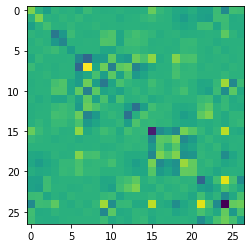

In [29]:
plt.imshow(H[0].detach().cpu().numpy())
plt.show()

## Calculating Hessians with batching

Hessians can take a long time to calculate, so it's helpful to speed up the process by batching the data and calculating the Hessians in parallel in each batch. This is especially true if you want to train on Hessians.

To calculate batched Hessians, we use the function `schnet_batched_hessians`, and make a DataLoader like we do during training:

In [74]:
from nff.nn.tensorgrad import schnet_batched_hessians
from torch.utils.data import DataLoader
from nff.data.loader import collate_dicts
from nff.utils.cuda import batch_to



In [75]:
loader = DataLoader(dataset, batch_size=50, collate_fn=collate_dicts)

`schnet_batched_hessians` requires us to specify the energy keys for which we want the Hessian. Here we just predict one energy, the ground state, so we set `energy_keys = ['energy']`. We'll go through each batch and call `schnet_batch_hessians`. The result is a dictionary, `hess_dic`, with keys corresponding to each energy key. We'll define an overall dictionary that we update as we go through the batches:



In [76]:
overall_hess = {}
energy_keys = ['energy']
device = 0

for batch in loader:
    
    # put the batch and model onto the GPU
        
    batch = batch_to(batch, device)
    model.to(device)
    
    # calculate the Hessian
    
    hess_dic = schnet_batched_hessians(batch=batch,
                                        model=model,
                                        device=device,
                                        energy_keys=energy_keys)
    
    # add the results to the overall dictionary
    
    for key, val in hess_dic.items():
        if key in overall_hess:
            overall_hess[key] = overall_hess[key] + val
        else:
            overall_hess[key] = val

The result is a dictionary whose keys are `[key + '_hess']` for all the energy keys:

In [77]:
overall_hess.keys()

dict_keys(['energy_hess'])

Let's visualize some of the Hessians:

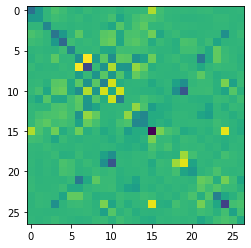

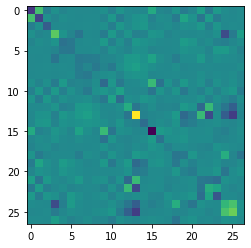

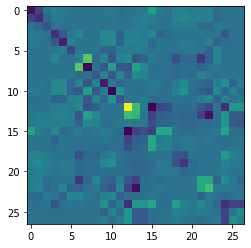

In [78]:
hess_sample = overall_hess["energy_hess"][:3]

for H in hess_sample:
    plt.imshow(H.detach().cpu().numpy())
    plt.show()

# What if the molecules in the batch have different sizes?

We can do batching for Hessians even if the molecules have different sizes! To show this we'll load another dataset with different azobenzene species. Since the dataset contains different species, the geometries have differing numbers of atoms. There are 1000 total geometries in this dataset.

We call the function in the exact same way, and it still works:

In [79]:
dset_2 = Dataset.from_file('./data/switch_demonstration.pth.tar')
# the dataset calls the energy `energy_0`, so we'll change it to `energy`
# for consistency with the other example

dset_2.props["energy"] = dset_2.props["energy_0"]

loader = DataLoader(dset_2, batch_size=50, collate_fn=collate_dicts)

In [80]:
%%time

overall_hess = {}
energy_keys = ['energy']
device = 0

for batch in loader:
        
    # put the batch and model onto the GPU
        
    batch = batch_to(batch, device)
    model.to(device)
    
    # calculate the Hessian
    
    hess_dic = schnet_batched_hessians(batch=batch,
                                        model=model,
                                        device=device,
                                        energy_keys=energy_keys)
    
    for key, val in hess_dic.items():
        if key in overall_hess:
            overall_hess[key] = overall_hess[key] + val
        else:
            overall_hess[key] = val

CPU times: user 29.7 s, sys: 312 ms, total: 30 s
Wall time: 19.4 s


It took only 20 seconds to compute 1000 Hessians of different species! (That's 50 Hessians per second, or about one second per batch).

We can sample different species and look at some of their Hessians:

In [85]:
smiles_list = list(set(dset_2.props["smiles"]))[:5]

sample_idx = []
for smiles in smiles_list:
    idx = [i for i, s in enumerate(dset_2.props["smiles"]) if s == smiles ][0]
    sample_idx.append(idx)
    
hess_sample = [overall_hess["energy_hess"][i] for i in sample_idx]



We can see their Hessians, and also note that the Hessians have different dimensions as the species are different:

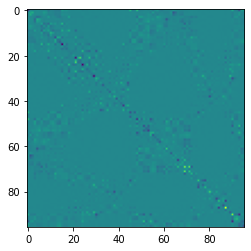

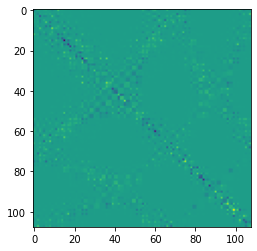

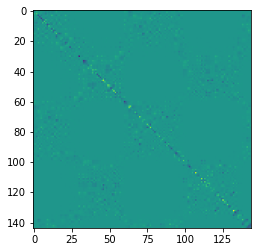

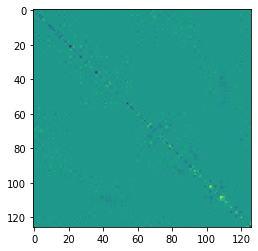

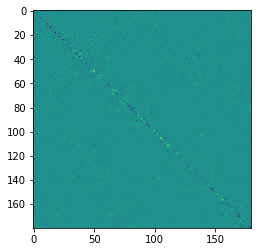

In [86]:
for H in hess_sample:
    plt.imshow(H.detach().cpu().numpy())
    plt.show()

To check that the Hessians are actually right, we can sample some of them and compare them to the non-batched results:

In [87]:
batch = {}
for i, idx in enumerate(sample_idx):
    sample_dset = copy.deepcopy(dset_2)

    for key, val in dset_2.props.items():
        sample_dset.props[key] = val[idx: idx + 1]

    loader = DataLoader(sample_dset, batch_size=50, collate_fn=collate_dicts)
    batch = next(iter(loader))
    batch = batch_to(batch, device)
    model.to(device)

    H = get_schnet_hessians(batch, model, device=device)
    batched_H = hess_sample[i]

    delta = abs(H - batched_H.reshape(*H.shape)).mean()
    rel_err = delta / abs(H).mean()
    
    print("Relative error is %.2e" % rel_err)

Relative error is 5.61e-07
Relative error is 5.37e-07
Relative error is 5.90e-07
Relative error is 5.35e-07
Relative error is 6.10e-07


All working!